# **Time Series Analysis - Project Part 2**

## Group 3

* Ayana Holla Pandeshwara (Team lead)
* Shubham Patil
* Vineela Kunisetti

In [ ]:
!pip install pmdarima

In [ ]:
import pmdarima as pm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot, lag_plot
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Data Preprocessing

In [ ]:
fuelprice_df = pd.read_csv('/content/weekly_fuel_prices_all_data_from_2005_to_20221102-1.csv')

In [ ]:
fuelprice_df.shape
fuelprice_df

,SURVEY_DATE,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
0,03-01-2005,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
1,03-01-2005,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2,03-01-2005,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
3,03-01-2005,5,LPG,552.50,92.08,156.62,303.80,0.22
4,03-01-2005,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...,...
5353,31-10-2022,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
5354,31-10-2022,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
5355,31-10-2022,5,LPG,777.79,140.26,100.44,537.09,-9.45
5356,31-10-2022,6,Residual fuel oil,1223.00,111.18,166.84,944.98,-1.91


In [ ]:
#Converting 'SURVEY_DATE' attribute to datetime format and setting it as index
fuelprice_df['SURVEY_DATE'] = pd.to_datetime(fuelprice_df['SURVEY_DATE'], dayfirst=True)
fuelprice_df.set_index('SURVEY_DATE', inplace=True)

In [ ]:
#Check for missing values and duplicate entries
missing_values_check = fuelprice_df.isnull().values.any()
duplicates_values_check = fuelprice_df.index.duplicated().sum()
#Getting unique product IDs to understand how many different products we have
unique_product_ids = fuelprice_df['PRODUCT_ID'].unique()

missing_values_check, duplicates_values_check, unique_product_ids, fuelprice_df.head()

(False,
 4465,
 array([1, 2, 3, 5, 6, 8]),
              PRODUCT_ID        PRODUCT_NAME    PRICE     VAT  EXCISE     NET  \
 SURVEY_DATE                                                                    
 2005-01-03            1       Euro-Super 95  1115.75  185.96  558.64  371.15   
 2005-01-03            2  Automotive gas oil  1018.28  169.71  403.21  445.36   
 2005-01-03            3     Heating gas oil   948.50  158.08  403.21  387.21   
 2005-01-03            5                 LPG   552.50   92.08  156.62  303.80   
 2005-01-03            6   Residual fuel oil   553.25   50.30  166.84  336.11   
 
              CHANGE  
 SURVEY_DATE          
 2005-01-03    -1.57  
 2005-01-03    -0.33  
 2005-01-03   -22.55  
 2005-01-03     0.22  
 2005-01-03   -12.21  )

The dataset doesn't have any missing values in its columns, but there are 4,465 duplicated entries based on the survey date. There are six unique products identified by their product IDs: 1, 2, 3, 5, 6, and 8.
Since we have duplicates based on the survey date, we'll use the method of averaging the prices for any duplicates within the same week and product ID in the next block of code

<ipython-input-10-1c4f2439db1a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cleaned_df = fuelprice_df.groupby([fuelprice_df.index, 'PRODUCT_ID']).mean().reset_index().set_index('SURVEY_DATE')


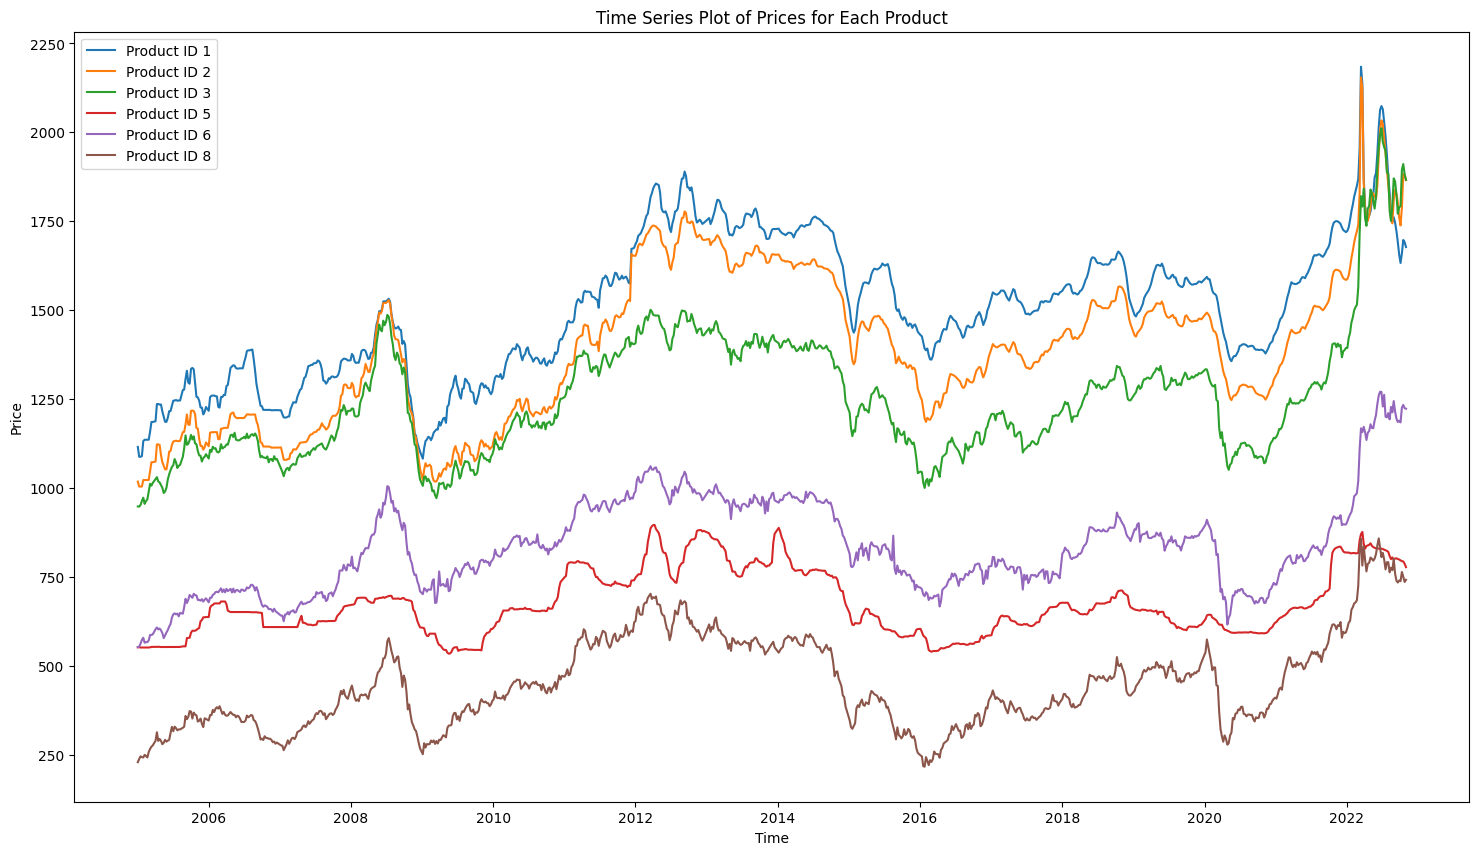

In [ ]:
#Remove duplicate record by averaging the prices for all duplicates within the same week and product ID
cleaned_df = fuelprice_df.groupby([fuelprice_df.index, 'PRODUCT_ID']).mean().reset_index().set_index('SURVEY_DATE')
#Plotting each product's price over time separately
plt.figure(figsize=(18, 10))
#For each product ID, plot the time series
for product_id in unique_product_ids:
    product_data = cleaned_df[cleaned_df['PRODUCT_ID'] == product_id]
    plt.plot(product_data.index, product_data['PRICE'], label=f'Product ID {product_id}')

plt.title('Time Series Plot of Prices for Each Product')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Above plot shows a line plot for each product's price over time on the same graph to visually compare their trends. The time series plot for each product above shows how the prices have varied over time, providing a clear visual comparison between the different products.

In [ ]:
#Check for missing weeks in the time series after creating a time range from the minimum to the maximum date in the dataset
complete_time_range = pd.date_range(start=cleaned_df.index.min(), end=cleaned_df.index.max(), freq='W-MON')
#Number of rows
rows_per_product = cleaned_df['PRODUCT_ID'].value_counts().sort_index()

complete_time_range, rows_per_product

(DatetimeIndex(['2005-01-03', '2005-01-10', '2005-01-17', '2005-01-24',
                '2005-01-31', '2005-02-07', '2005-02-14', '2005-02-21',
                '2005-02-28', '2005-03-07',
                ...
                '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19',
                '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17',
                '2022-10-24', '2022-10-31'],
               dtype='datetime64[ns]', length=931, freq='W-MON'),
 1    893
 2    893
 3    893
 5    893
 6    893
 8    893
 Name: PRODUCT_ID, dtype: int64)

The complete time range i.e there exists a continuous timeline from January 3, 2005, to October 31, 2022, with a weekly frequency on Mondays, totaling 931 weeks. Upon cleaning and averaging duplicates, each product has 893 records. This indicates there might be gaps (missing weeks) in the dataset for each product since the number of records is less than the total number of weeks in the complete time range. This is addressed in the next block of code

In [ ]:
#DataFrame to track missing weeks for each product
missing_weeks_df = pd.DataFrame()

for product_id in unique_product_ids:
    #Filtering the dataset for the current product ID and reindex the product data
    product_data = cleaned_df[cleaned_df['PRODUCT_ID'] == product_id]
    reindexed_data = product_data.reindex(complete_time_range, method=None)
    #Identify the missing weeks
    missing_weeks = reindexed_data[reindexed_data.isna().any(axis=1)].index
    #Add the missing weeks for the current product ID to the dataframe to track them
    missing_weeks_df = pd.concat([missing_weeks_df, pd.DataFrame({'PRODUCT_ID': product_id, 'Missing Week': missing_weeks})])

#Reseting the index of the missing weeks DataFrame
missing_weeks_df.reset_index(drop=True, inplace=True)
#Total number of missing weeks for each product and a sample of the missing weeks data
total_missing_weeks_per_product = missing_weeks_df['PRODUCT_ID'].value_counts().sort_index()
missing_weeks_df_sample = missing_weeks_df.sample(5)

total_missing_weeks_per_product, missing_weeks_df_sample

(1    39
 2    39
 3    39
 5    39
 6    39
 8    39
 Name: PRODUCT_ID, dtype: int64,
      PRODUCT_ID Missing Week
 202           8   2007-12-24
 118           5   2005-08-15
 95            3   2012-12-24
 93            3   2011-08-15
 97            3   2013-01-07)

For each product (identified by product IDs 1, 2, 3, 5, 6, and 8), there are 39 missing weeks in the dataset where we have no recorded data. This consistency is across all products and suggests a systematic gap in the dataset rather than random missing entries, which might be due to holidays, data collection policies, or other factors occured during that period of time. The next step is to decide how to fill in these gaps.

Considering the nature of fuel price data, which can be influenced by various economic, coroporate restructuring, war and geopolitical factors on a week-to-week basis, we find linear interpolation might be a suitable method for filling in the missing weeks. This approach provides a reasonable estimate for the missing prices by assuming a linear trend between the known data points before and after each missing week.
If the fuel price was a stable plot then forward filling would be a simpelr implementation but as we all know fuel price is never constant.

In [ ]:
#Filling in the gaps using linear interpolation for each product
filled_df = pd.DataFrame()

for product_id in unique_product_ids:
    #Filtering the dataset for the current product ID and reindex the product data to ensure all weeks are accounted for
    product_data = cleaned_df[cleaned_df['PRODUCT_ID'] == product_id]
    reindexed_data = product_data.reindex(complete_time_range, method=None)
    #Filling in missing values
    interpolated_data = reindexed_data.interpolate(method='linear')
    #Combining the interpolated data back into DataFrame
    filled_df = pd.concat([filled_df, interpolated_data])
#Final check for any more missing values in the filled dataset
missing_after_interpolation_check = filled_df.isnull().any()

filled_df.head(), missing_after_interpolation_check


(            PRODUCT_ID    PRICE     VAT  EXCISE     NET  CHANGE
 2005-01-03         1.0  1115.75  185.96  558.64  371.15   -1.57
 2005-01-10         1.0  1088.00  181.33  558.64  348.03  -27.75
 2005-01-17         1.0  1088.14  181.36  558.64  348.14    0.14
 2005-01-24         1.0  1090.01  181.67  558.64  349.70    1.87
 2005-01-31         1.0  1132.11  188.68  558.64  384.79   42.10,
 PRODUCT_ID    False
 PRICE         False
 VAT           False
 EXCISE        False
 NET           False
 CHANGE        False
 dtype: bool)

Now we have a complete time series dataset for each product, with continuous data from January 2005 to October 2022, including the previously missing weeks. Now we are ready to proceed with Project Part 2.
Since we have multiple time series in our dataset i.e for different products we have different timelines so each person from the team has choosen one of the products and have followed all the steps required for project part 2 respectively.

# Product ID 1
Here we have started with product ID 1 which is Euro-Super 95.

### DECOMPOSITION
As per our reading, Additive models are typically used when the seasonal variations are roughly the same magnitude over time, which seems to be the case here for product id 1 as the seasonal amplitude doesn't appear to increase with the level of the time series. So were proceed to decompose applying the additive model.

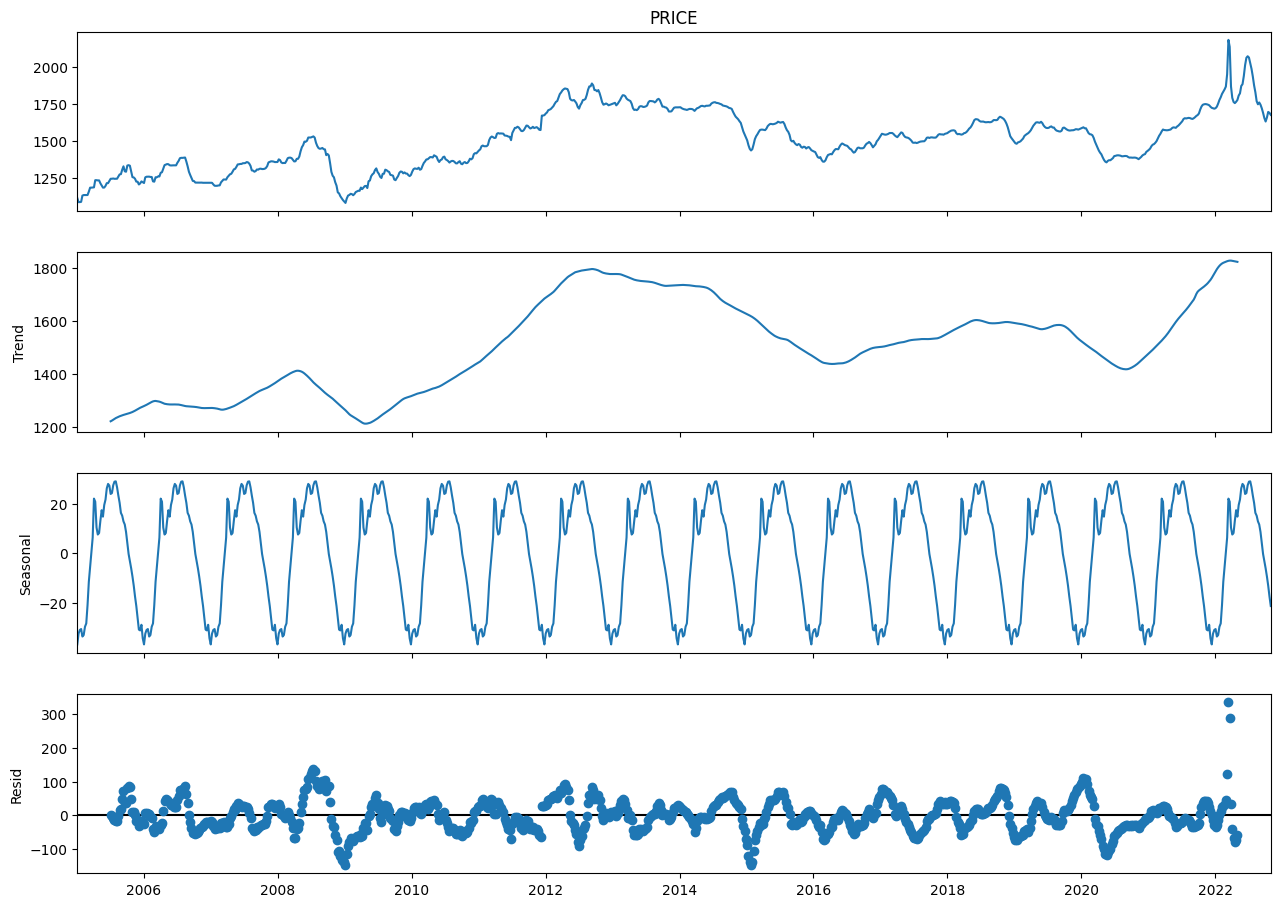

In [ ]:
#Selecting only Product ID 1 data for further analysis
product_id_1_data = filled_df[filled_df['PRODUCT_ID'] == 1]['PRICE']
#Performing seasonal decomposition on Weekly data, hence period=52 and ssuming an additive model at first
decomposition = seasonal_decompose(product_id_1_data, model='additive', period=52)
#Plot
decomposed_fig = decomposition.plot()
decomposed_fig.set_size_inches(14, 10)
plt.show()

On analyzing the plot and its three components we understand:
There is an apparent upward movement in the trend component starting around 2016, suggesting that there is a long-term increase in the price of Euro-Super 95. Before this, the trend is relatively stable with slight increase and decreases . This indicates that while there were fluctuations in the early part of the series, a clear upward trend in prices becomes noticeable in the later part.
Coming to the Seasonal Component there is a repeating pattern visible within each year in the seasonal component. This indicates that the data exhibits seasonality — regular fluctuations that repeat over a set period. In this case, the pattern repeats annually, suggesting that the price of Euro-Super 95 is subject to seasonal factors, which could be related to changes in demand across different seasons, along with aother factors.
Lastly the residuals appear to be relatively stable and low in magnitude, which indicates that the additive model chosen for the decomposition has captured the trend and seasonal patterns reasonably well. There are some spikes, but they do not seem to follow a regular pattern, suggesting these may be irregular or one-off fluctuations.
Based on the decomposition, we can conclude that the time series for Euro-Super 95 prices shows both trend and seasonality. The trend is a long-term component that captures the general direction of the data over time and the seasonality captures regular fluctuations within each year.

### VISUALIZATIONS

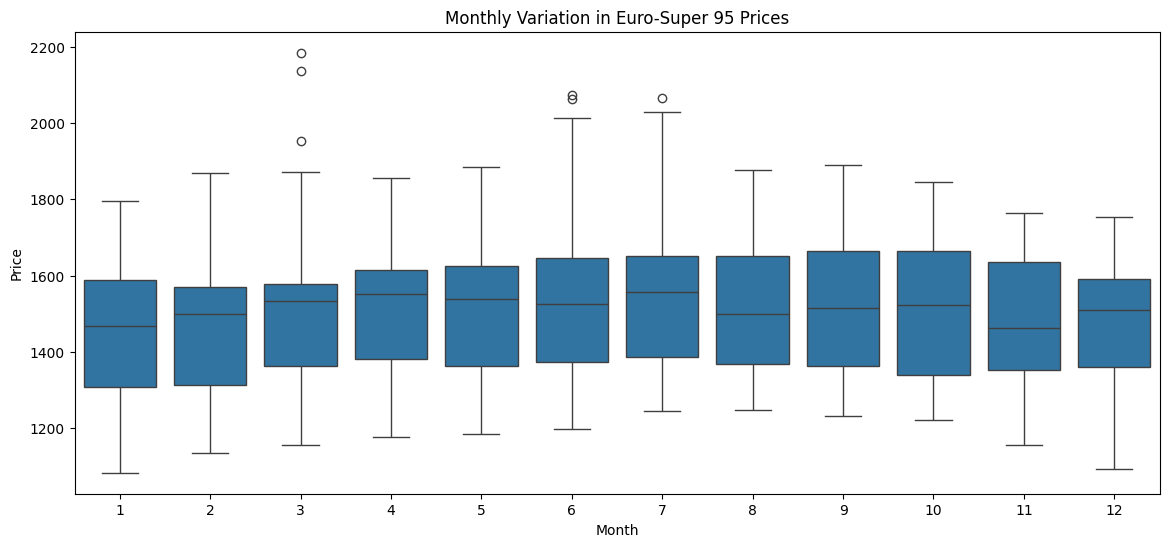

In [ ]:
#Box Plot of Prices by Month
plt.figure(figsize=(14, 6))
sns.boxplot(x=product_id_1_data.index.month, y=product_id_1_data.values)
plt.title('Monthly Variation in Euro-Super 95 Prices')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

This visualization provides a monthly breakdown of the prices, showcasing the median, quartiles, and any outliers within each month. It's useful for spotting seasonal trends and variations in price throughout the year, as well as identifying months with particularly high or low prices.
Price variation here is relatively consistent across months, as seen by the similar IQRs.
There is a tendency for some months like the 3rd and 9th to have a wider range of prices, suggesting greater variability in prices during those months.
Several months exhibit outliers, which are higher than the typical price range for those months. This could indicate sporadic spikes in fuel prices.
The median prices do not fluctuate dramatically month to month, suggesting that while there may be spikes, the central tendency of prices remains steady.

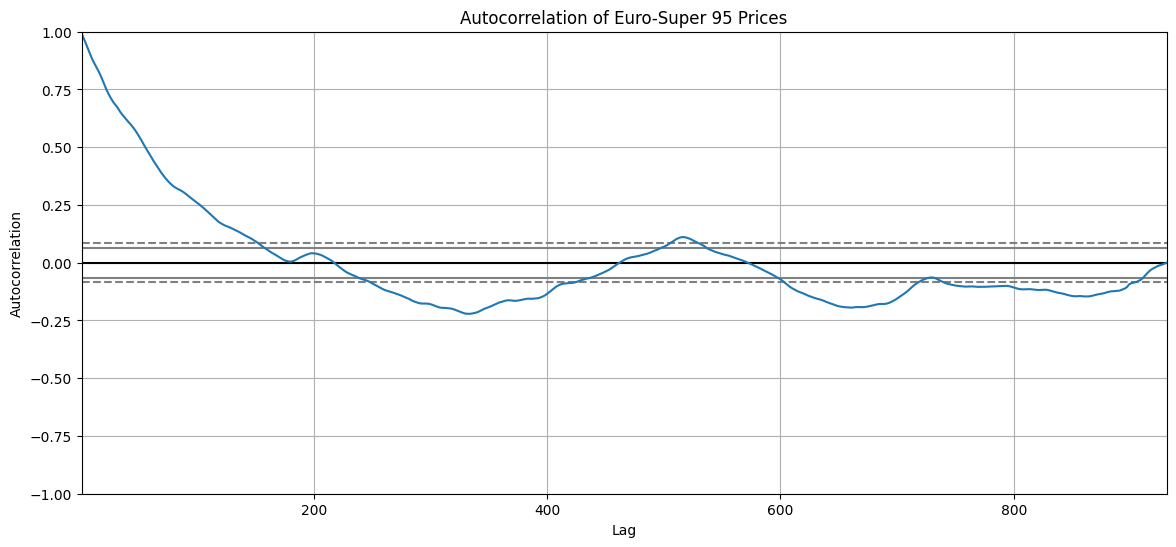

In [ ]:
#Autocorrelation Plot (ACF)
plt.figure(figsize=(14, 6))
autocorrelation_plot(product_id_1_data)
plt.title('Autocorrelation of Euro-Super 95 Prices')
plt.show()

The autocorrelation plot shows how the prices of Euro-Super 95 are correlated with their lagged values, offering insights into the cyclic patterns and the degree of serial correlation. Peaks in the plot suggest a strong seasonal effect or recurring patterns at specific lags.

### TIME SERIES DESCRIPTION

Due to the presence of trend and seasonality, the time series is non-stationary, meaning the statistical properties of the series change over time. To test for stationarity, we use the Augmented Dickey-Fuller (ADF) test. The null hypothesis of the ADF test is that the time series has a unit root, meaning it is non-stationary. A rejection of the null hypothesis suggests that the series is stationary.


In [ ]:
#Augmented Dickey-Fuller test to check for stationarity
adf_test = adfuller(product_id_1_data)
adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output


Test Statistic                  -2.693066
p-value                          0.075246
#Lags Used                       3.000000
Number of Observations Used    927.000000
Critical Value (1%)             -3.437424
Critical Value (5%)             -2.864663
Critical Value (10%)            -2.568433
dtype: float64

For the time series to be considered stationary at the 5% significance level, the test statistic would need to be below the critical value at 5%, which is -2.864663. Since this is not the case, we fail to reject the null hypothesis at the 5% significance level.
The p-value is usually taken at 0.05. Our p-value(0.075246) is above this threshold, we cannot reject the null hypothesis and conclude that the series is non-stationary.
Based on the ADF test results, we cannot conclude that the Euro-Super 95 prices are stationary.
The ADF test complements our previous step where we identified an upward trend and seasonal patterns in the data, both of which are characteristics of a non-stationary time series.
The next step is differencing the series to remove the trend and seasonality, transforming the series to stabilize the variance and/or using time series models that can handle non-stationarity, such as ARIMA with differencing or seasonal decomposition models like SARIMA from SARIMAX.

### TS MODELS

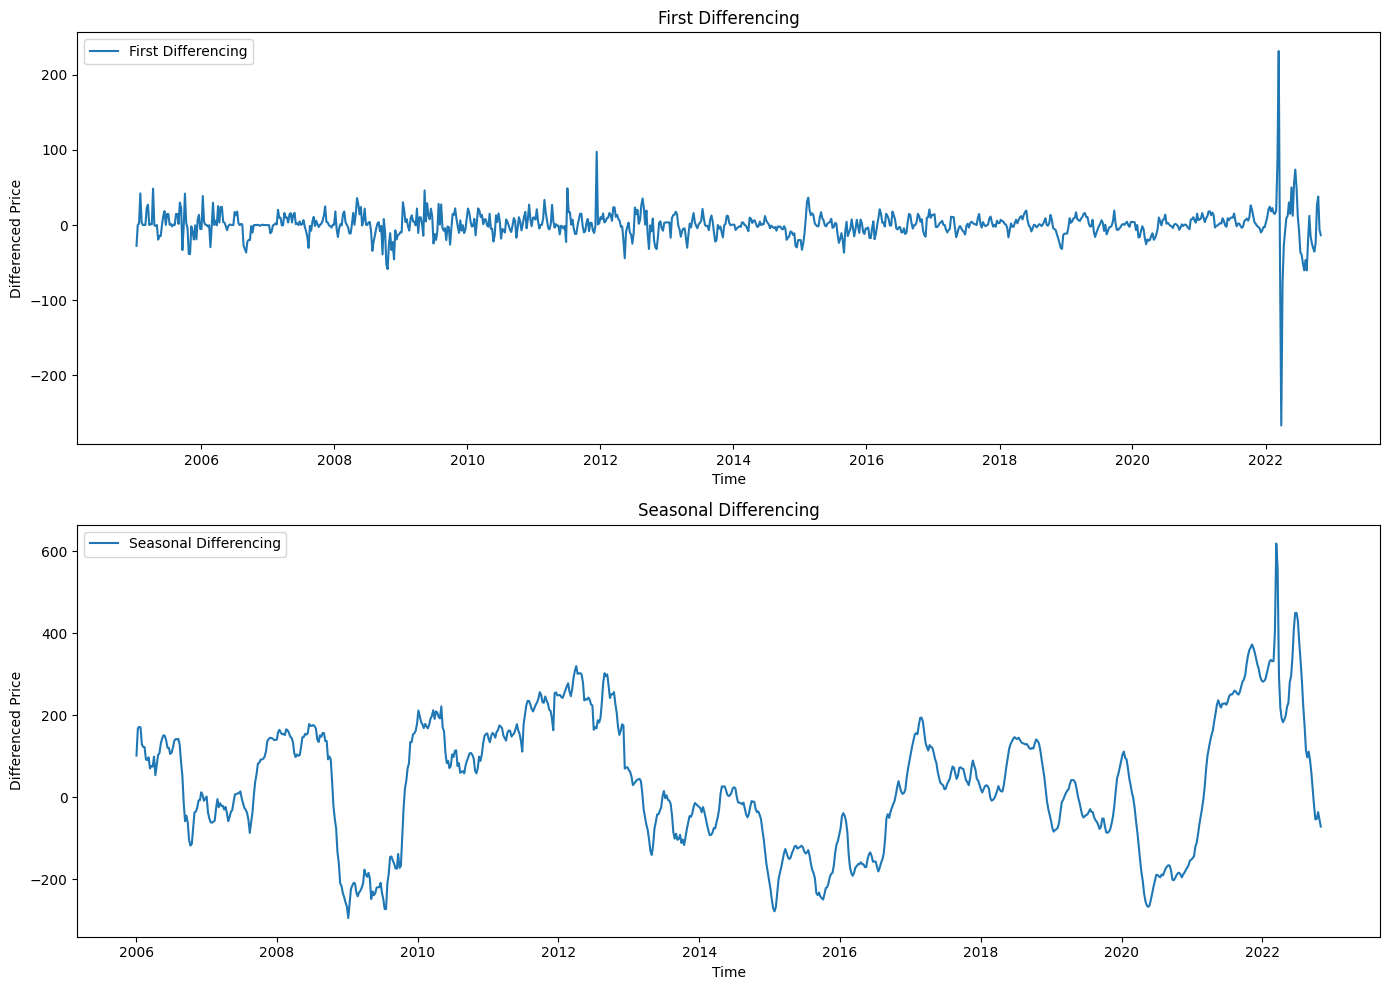

In [ ]:
#Applying differencing to stabilize the mean
#First differencing
first_diff = product_id_1_data.diff().dropna()
#Seasonal differencing (lag of 52 weeks)
seasonal_diff = product_id_1_data.diff(52).dropna()

#Plot the differenced data
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

#First Differencing plot
ax[0].plot(first_diff, label='First Differencing')
ax[0].set_title('First Differencing')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Differenced Price')
ax[0].legend()

#Seasonal Differencing plot
ax[1].plot(seasonal_diff, label='Seasonal Differencing')
ax[1].set_title('Seasonal Differencing')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Differenced Price')
ax[1].legend()

plt.tight_layout()
plt.show()

The first difference of the series has removed the trend component, as evidenced by the fact that the mean of the differenced series appears to be nearer to around zero. However, there are spikes which suggest possible outliers or large one-time changes, possibly due to external factors.
The seasonal differencing seems to have reduced the seasonality, as indicated by the removal of the periodic pattern seen in the original series.
Since both first and seasonal differencing appear to remove different components (trend and seasonality, respectively), and we have a prominent spike to address, we use a SARIMA model. This model can account for both the non-seasonal and seasonal structures in our data, including any outliers.

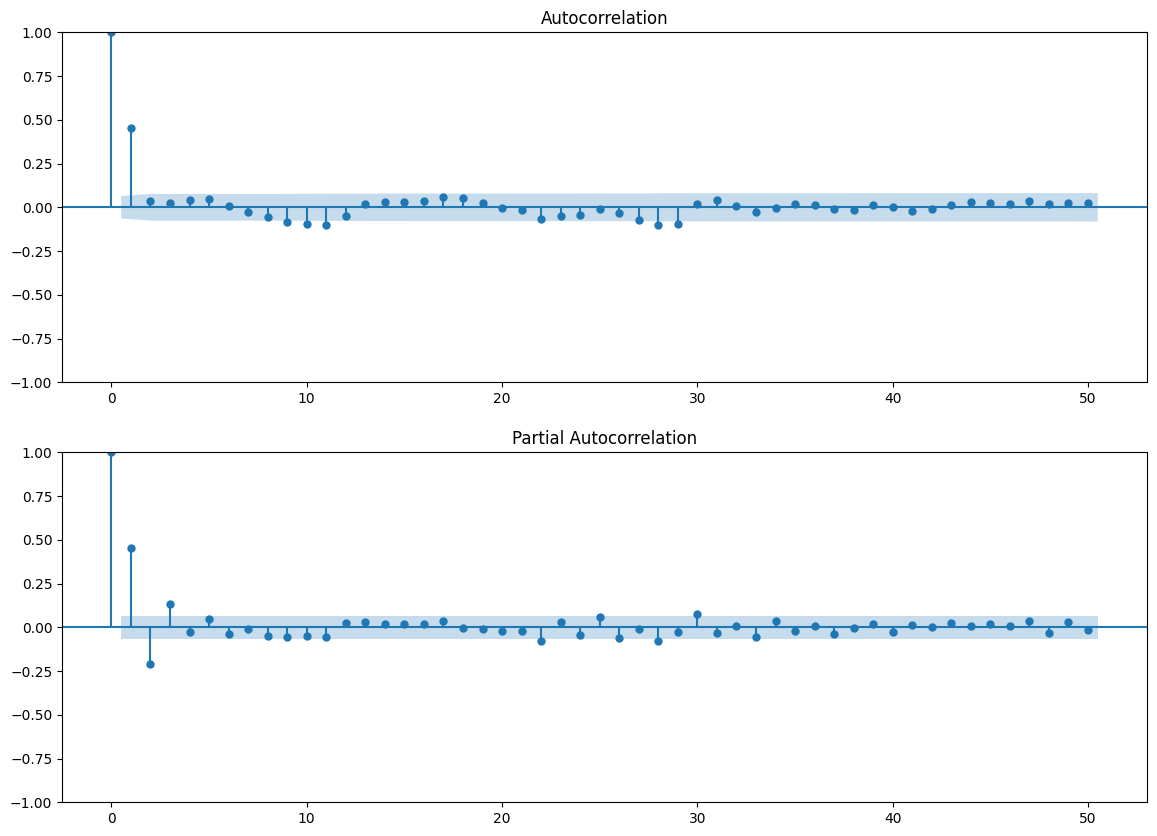

In [ ]:
#to fit ARIMA Model - Generate ACF and PACF plots on the differenced data

#The ACF and PACF plots
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(first_diff, lags=50, ax=axes[0])
plot_pacf(first_diff, lags=50, ax=axes[1], method='ywm')

plt.show()

The autocorrelation function (ACF) plot shows significant autocorrelation at lag 0 and seems to cut off quickly, which is characteristic of a series that has been differenced to remove a trend.
The partial autocorrelation function (PACF) plot shows a significant spike at lag 1 and then cuts off, suggesting an AR(1) component might be sufficient for the ARIMA model.

With the above analysis, a possible ARIMA model to start with could be ARIMA(1,1,0). This means one autoregressive term (because the PACF plot shows one significant spike at lag 1), one differencing (because you've already differenced the data once), and no moving average term (as the ACF plot doesn't show significant spikes beyond the immediate lag).
Fit the ARIMA(1,1,0) model to the first differenced data is done in the following block
The term "SARIMAX" is used by the statsmodels package as a more general term that encompasses ARIMA as a specific case and ofcourse SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  PRICE   No. Observations:                  931
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3944.360
Date:                Tue, 02 Apr 2024   AIC                           7892.720
Time:                        14:12:44   BIC                           7902.390
Sample:                    01-03-2005   HQIC                          7896.408
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4524      0.007     67.891      0.000       0.439       0.465
sigma2       282.6869      2.138    132.237      0.000     278.497     286.877
Ljung-Box (L1) (Q):                   8.34   Jarque-

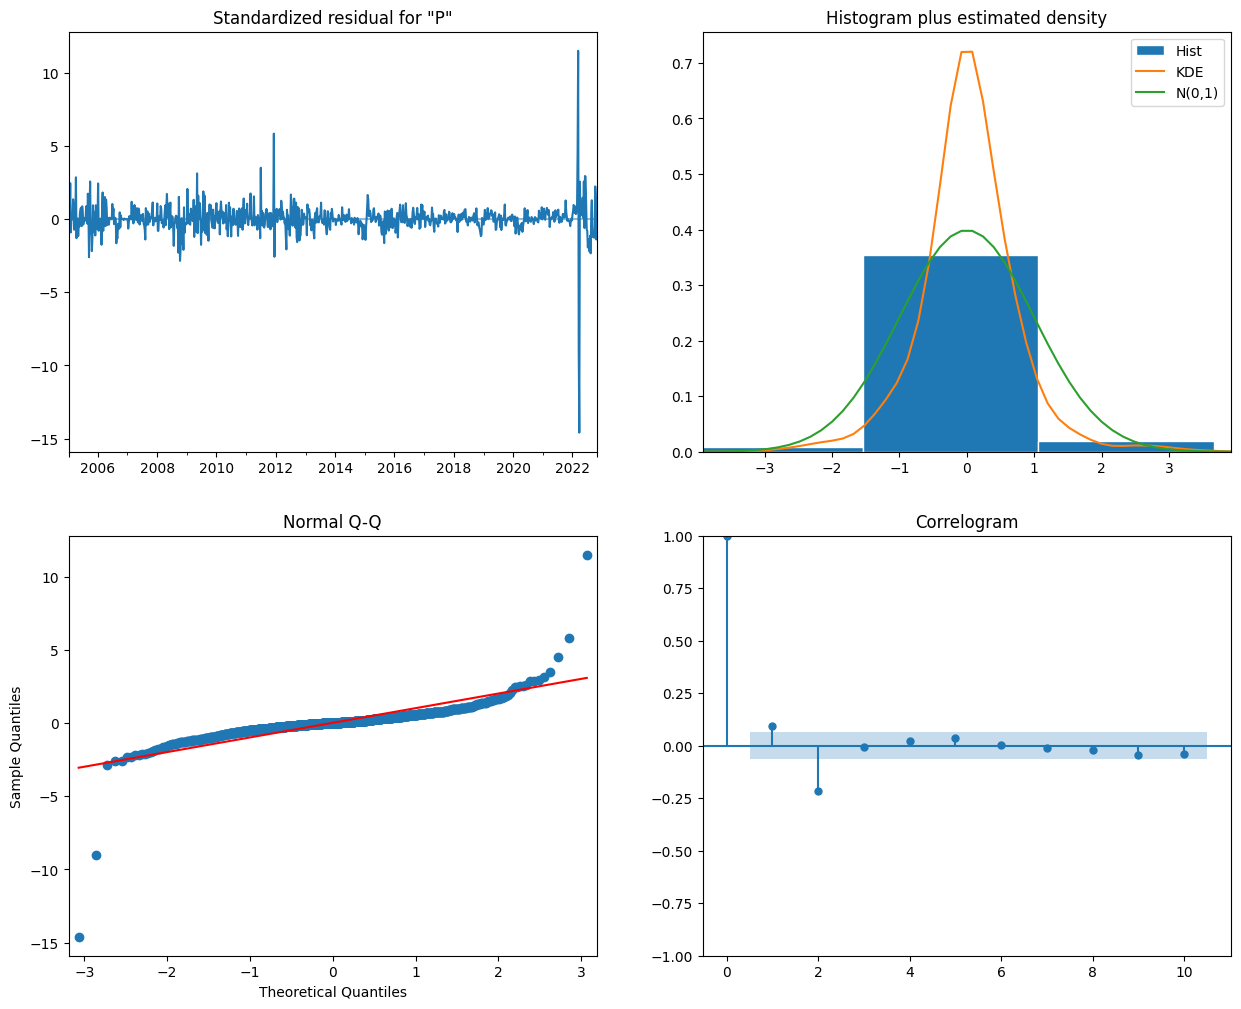

In [ ]:
#ARIMA Model
#Since PACF showed a significant spike at lag 1, we start with ARIMA(1,1,0)
arima_model = ARIMA(product_id_1_data, order=(1, 1, 0))
arima_results = arima_model.fit()
print(arima_results.summary())

#Plots for ARIMA model
arima_results.plot_diagnostics(figsize=(15, 12))
plt.show()



Top Left (Standardized Residuals):The residuals do not show obvious patterns, which is good; however, the presence of the spike suggests an exceptional event or outlier that the model didn't capture.
Top Right (Histogram plus Estimated Density):The histogram indicates the residuals are not perfectly normally distributed, as there is some deviation from the normal curve.
Bottom Left (Normal Q-Q):The Q-Q plot suggests non-normality in the tails of the residual distribution, which can affect the confidence intervals and prediction intervals of forecasts.
Bottom Right (Correlogram):The correlogram suggests that there is no significant autocorrelation in the residuals, meaning the model has captured the time series' autocorrelation well.

These diagnostics suggest that the ARIMA(1,1,0) model does not perfectly fit the data. Overall, the diagnostics suggest that while the ARIMA model captures much of the time series behavior, there may be some non-normality in the residuals due to heavy tails or an outlier, as seen in the spike. Additionally, the deviation from the normal line in the Q-Q plot suggests that the residual distribution has heavier tails than a normal distribution, which might affect the model's predictions.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              PRICE   No. Observations:                  931
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -3822.920
Date:                            Tue, 02 Apr 2024   AIC                           7651.841
Time:                                    14:13:07   BIC                           7666.174
Sample:                                01-03-2005   HQIC                          7657.322
                                     - 10-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4487      0.008     53.457      0.000       0.432       0.465
ar.S.L52      -0.4527      0.029   

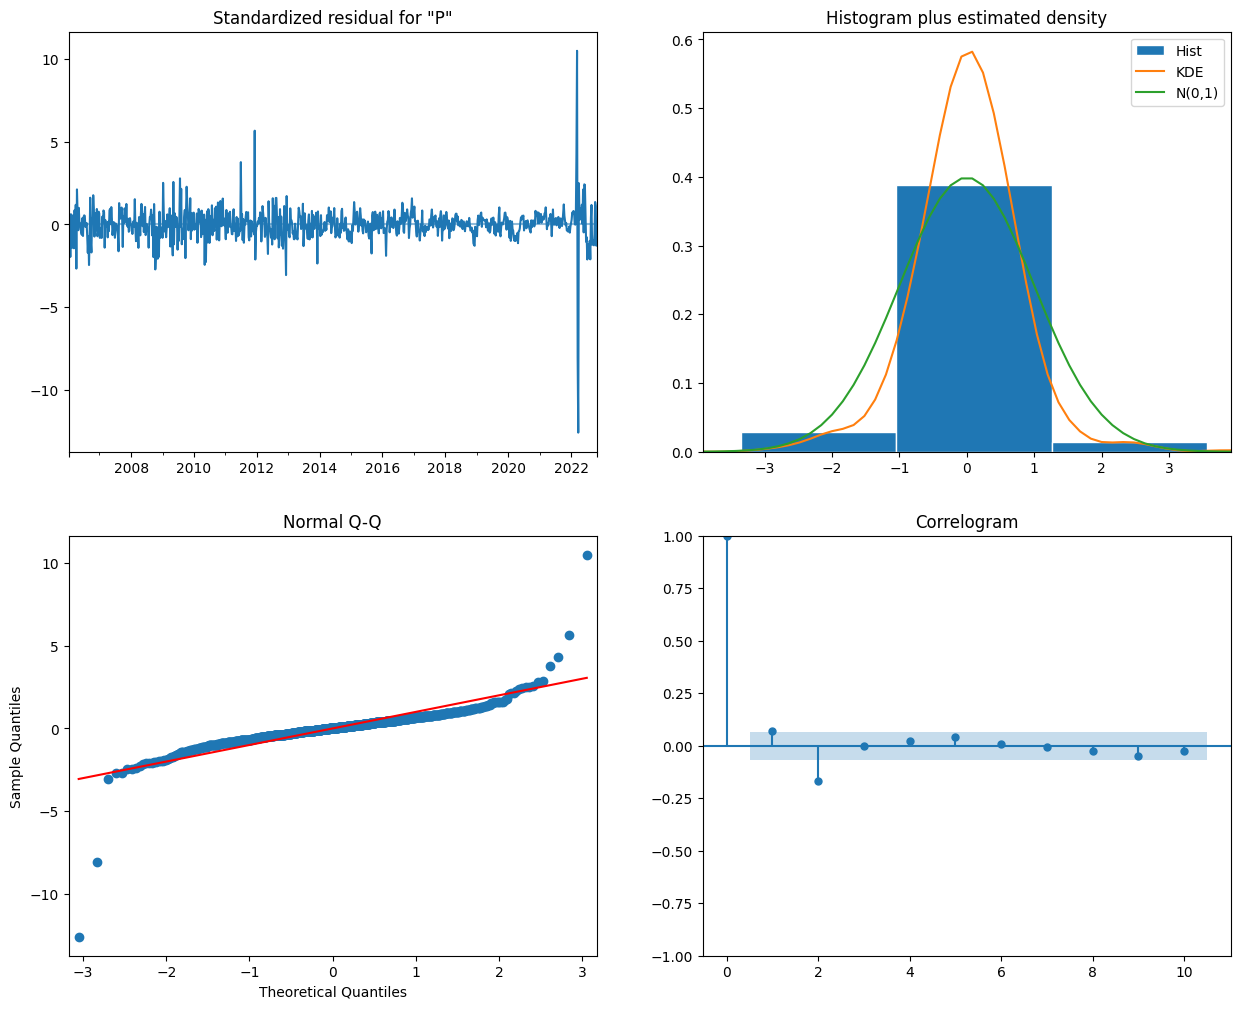

In [ ]:
#SARIMA Model
#Assuming there is significant seasonality with a period of 52 weeks based on prior analysis in decomposition where we saw it to be seasonal
sarima_model = SARIMAX(product_id_1_data, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52))
sarima_results = sarima_model.fit()
print(sarima_results.summary())
#Plots for SARIMA model
sarima_results.plot_diagnostics(figsize=(15, 12))
plt.show()

Based on the SARIMA results, it appears that the seasonal component is significant (given the p-value of the seasonal AR term is less than 0.05). This suggests that the seasonality is an important aspect of product 1 time series and that the SARIMA model is capturing that.The SARIMA model seems to have a lower AIC/BIC and reasonable diagnostics indicating a better fit.

auto arima trials:-
Based on input from TA and what was learnt in previosu week assignment tried to incoporate a auto arima.
auto arima model is demanding alot of computational resources, especially when the dataset is this large/the seasonal period is long (such as 52 weeks for weekly data).We have tried it repeatedly by reducing complexity and also taking one model at a time as you can see below but the code is crashing after almost 5 different tries with different values to limit the search step wise and one model at a time but its not being supported on gogole collab and keeps crashing. Hence proceeding with SARIMA model which is the best model so far for product is 1.
Kept the code to show that attempt was made but its not possible.

In [ ]:
#first try
# auto_model = pm.auto_arima(product_id_1_data, seasonal=True, m=52,
#                            stepwise=True, suppress_warnings=True,
#                            D=1, max_p=5, max_q=5, max_P=2, max_Q=2,
#                            trace=True, error_action='ignore')
# print(auto_model.summary())
# auto_model.plot_diagnostics(figsize=(15, 12))
# plt.show()

#changes done in next trials
# Running auto_arima again with restricted parameters mentioned below to reduce complexity as ram is crashing with above values
# auto_model = pm.auto_arima(product_id_1_data, seasonal=True, m=52,
#                            stepwise=True, suppress_warnings=True,
#                            D=1, max_p=3, max_q=3, max_P=1, max_Q=1,
#                            trace=True, error_action='ignore',
#                            start_p=0, start_q=0, start_P=0, start_Q=0,
#                            max_order=6,  # Total sum of p, d, q, P, D, Q
#                            max_d=2, max_D=1)


# Running auto_arima with even more restricted parameters to save on RAM and prevent crashing
# #auto_model = pm.auto_arima(product_id_1_data, seasonal=True, m=52,
#                            stepwise=True, suppress_warnings=True,
#                            D=1, max_p=2, max_q=2, max_P=1, max_Q=1,
#                            trace=True, error_action='ignore',
#                            start_p=0, start_q=0, start_P=0, start_Q=0,
#                            max_order=5,
#                            max_d=1, max_D=1,  # Reduce the number of differences
#                            n_fits=1)  # Limit the number of models to try

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=7954.444, Time=3.58 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=7651.841, Time=9.77 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=26.56 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=7765.115, Time=1.34 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=29.90 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=26.22 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=7845.877, Time=8.11 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=7630.423, Time=14.19 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=7757.161, Time=2.21 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=57.97 sec


## PREDICTIONS

Initially a forecast with 52 weeks was visualized using the SARIMA model which was not very conclusive of how the plot would progress so then we generate an extended forecast for a period of 104 weeks into the future along with the confidence intervals, providing a range of where the actual values are likely to fall. Key points are:
1. Time series has a strong trend component, this is a positive sign.
2. The forecast picks up from where the historical data ends and follows a similar plot as recent years

The widening confidence intervals (shaded area) as we move further out into the future represent increasing uncertainty in the forecasts. This is typical and expected; but it helps us understand the possible trend the prices may follow.

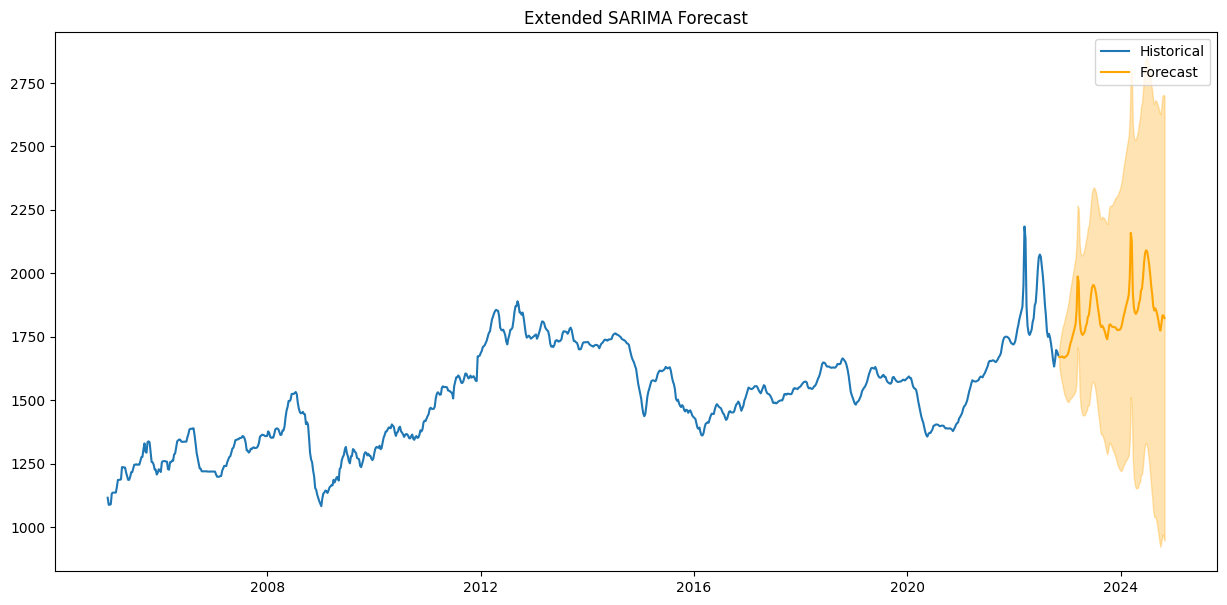

In [ ]:
#Our data is weekly, so this will be 52 weeks * 2
n_periods = 104

#Forecasting
forecast = sarima_results.get_forecast(steps=n_periods)
forecast_index = pd.date_range(product_id_1_data.index[-1] + pd.Timedelta(weeks=1), periods=n_periods, freq='W-MON')

#By default confidence intervals are typically calculated at the 95% level
pred_conf = forecast.conf_int()

#Plotting the historical data
plt.figure(figsize=(15, 7))
plt.plot(product_id_1_data.index, product_id_1_data, label='Historical')

#Plotting the forecast in orange
plt.plot(forecast_index, forecast.predicted_mean, color='orange', label='Forecast')

#Plotting the confidence intervals
plt.fill_between(forecast_index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='orange', alpha=0.3)

plt.title('Extended SARIMA Forecast')
plt.legend()
plt.show()


Decomposition revealed patterns within the data, where seasonality and trends were prominent, guiding our choice of the SARIMA model, which accounts for such recurring patterns. Diagnostic checks of the initial ARIMA model exposed residual patterns and non-normality. The selected SARIMA model, based on ACF and PACF plots, was more apt at modeling the data, proven by lower AIC and BIC values we got in the sumamry. The final forecasting plot shows the model's proficiency in tracing historical trends and projecting future prices. The trend line follows a similar path as the historic data and it is pertinent to current trend of high fuel prices in EU.

# **Product Id 2**
Here we have started with product ID 2 which is Automotive gas oil.

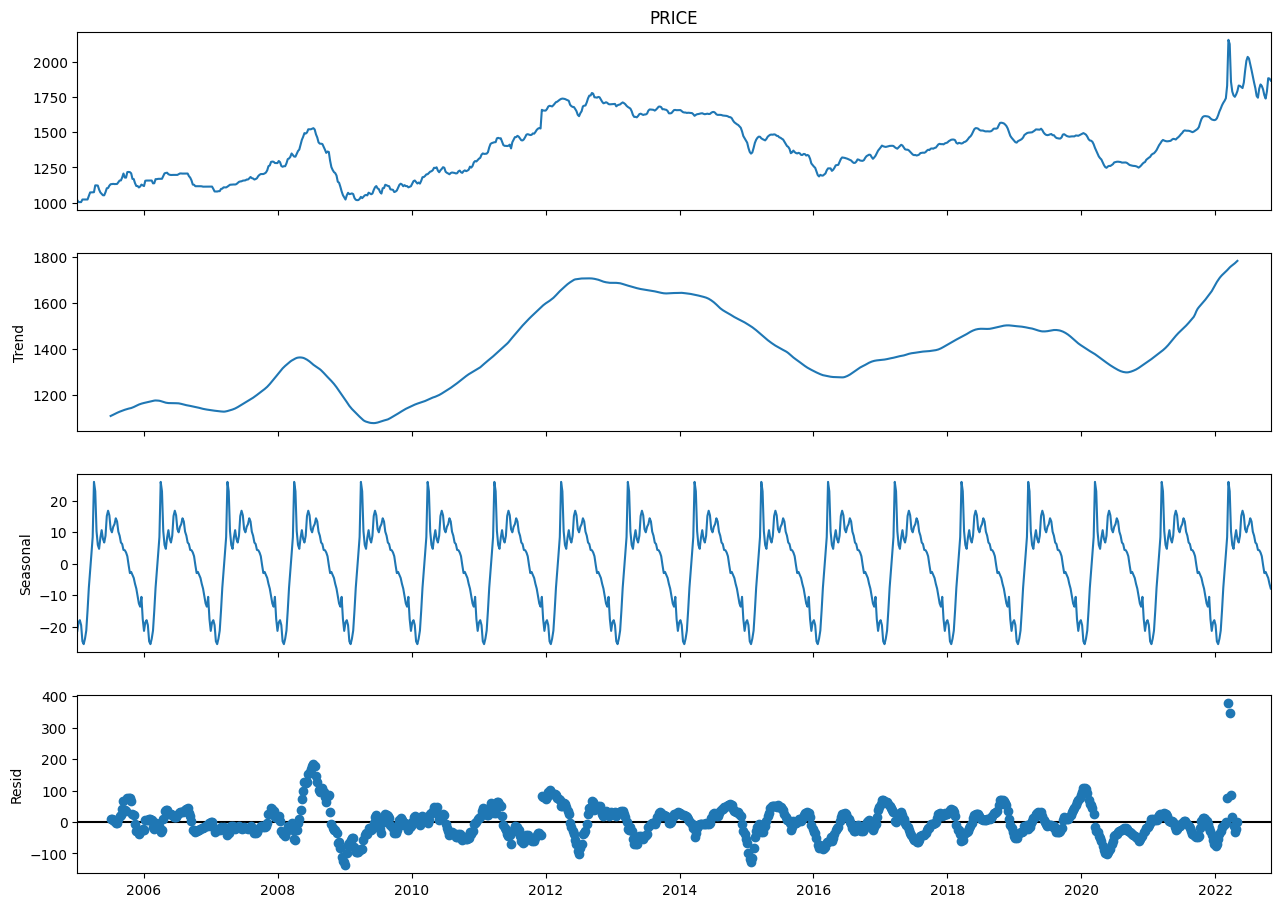

In [ ]:
product_id_2_data = filled_df[filled_df['PRODUCT_ID'] == 2]['PRICE']

decomposition = seasonal_decompose(product_id_2_data, model='additive', period=52)

# Gather the trend, seasonality and residuals of the decomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# decomposition.plot()
# decomposed_fig.set_size_inches(14, 10)

decomposed_fig = decomposition.plot()
decomposed_fig.set_size_inches(14, 10)
plt.show()

### VISUALIZATION

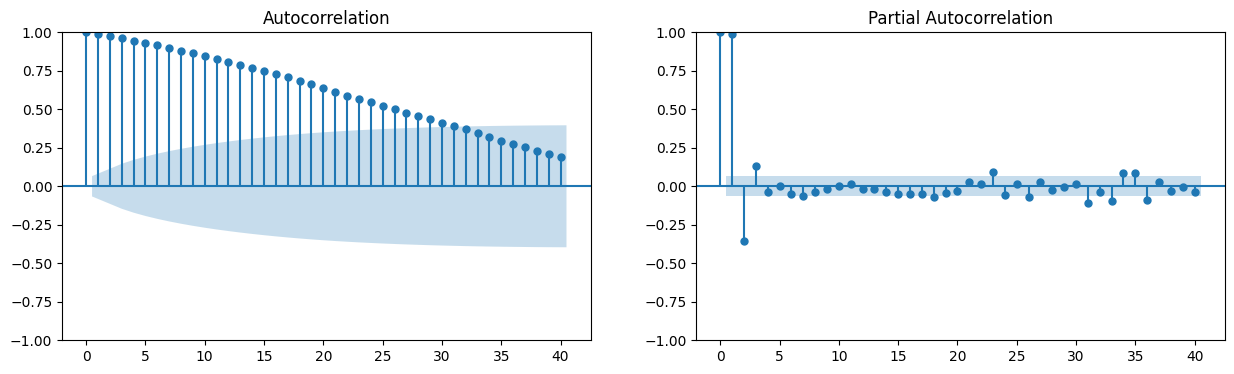

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

time_series = filled_df[filled_df['PRODUCT_ID'] == 2]['PRICE']

# Performing seasonal differencing on the data
seasonally_differenced = time_series.diff(52).dropna()

# Performing Augmented Dickey-Fuller test on seasonally differenced data
adf_test_seasonally_diff = adfuller(seasonally_differenced)

# Plotting ACF and PACF for the seasonally differenced data
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(seasonally_differenced, ax=axes[0], lags=40)
plot_pacf(seasonally_differenced, ax=axes[1], lags=40, method='ywm')
plt.show()

# ADF test results
adf_result_seasonally_diff = {
    'ADF Test Statistic': adf_test_seasonally_diff[0],
    'p-value': adf_test_seasonally_diff[1],
    'Number of Lags Used': adf_test_seasonally_diff[2],
    'Number of Observations Used': adf_test_seasonally_diff[3],
    'Critical Values': adf_test_seasonally_diff[4],
}




### TIME SERIES DESCRIPTION

In [ ]:
adf_result_seasonally_diff


{'ADF Test Statistic': -2.5034862545540233,
 'p-value': 0.11462838407690851,
 'Number of Lags Used': 3,
 'Number of Observations Used': 875,
 'Critical Values': {'1%': -3.4378455288562564,
  '5%': -2.8648487898906123,
  '10%': -2.5685318403265307}}

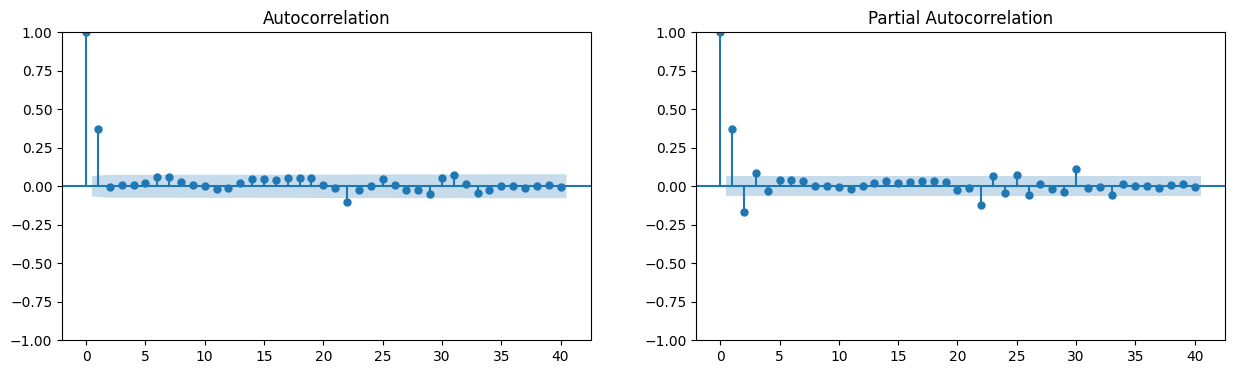

In [ ]:
# Further differencing
time_series_diff2 = seasonally_differenced.diff().dropna()

# Performing Augmented Dickey-Fuller test again
adf_test_diff2 = adfuller(time_series_diff2)

# Generating ACF and PACF plots for the further differenced data
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(time_series_diff2, ax=axes[0], lags=40)
plot_pacf(time_series_diff2, ax=axes[1], lags=40, method='ywm')
plt.show()

To analyze and forecast the time series data of fuel prices, we encountered several characteristic patterns that necessitated a robust statistical model. The SARIMAX model was chosen for several compelling reasons:

**Firstly**, the data exhibited clear seasonal fluctuations. This cyclic behavior, where prices exhibit predictable patterns at specific intervals (annually, in this case), is adeptly captured by the seasonal component of the SARIMAX model. The ability to model and adjust for this seasonality is paramount, as it allows for more accurate predictions that are sensitive to the time of year.

**Secondly**, the presence of an underlying trend in the data was evident. Unlike stationary series where properties do not depend on the time at which the series is observed, fuel prices demonstrated non-stationary characteristics, including trends over time. The SARIMAX model's integration feature is specifically designed to address such non-stationarity by differencing the data until it reaches stationarity, thus making the model suitable for our series which has both stochastic and deterministic trends.

**Thirdly**, the autocorrelation in the series - the correlation of the series with its past values - was a significant factor. The SARIMAX model accounts for this with its AutoRegressive component, which effectively utilizes past values to predict future ones.

Finally, an advantage of the SARIMAX model is its provision for prediction intervals, which offers a quantified measure of forecast uncertainty.

So in **conclusion**, the SARIMAX model was selected due to its comprehensive ability to capture both the non-stationarity and seasonality in the data, while also providing an effective framework for understanding and predicting the time series with its AR and MA components. This model not only fit the historical data well but also allowed for nuanced forecasting, making it the most suitable choice for our analysis.

### MODELS

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Fit SARIMA model
sarima_model = SARIMAX(time_series, order=(1, 1, 0), seasonal_order=(1, 1, 1, 52))
sarima_result = sarima_model.fit()

#summary of the model
print(sarima_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                PRICE   No. Observations:                  931
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 52)   Log Likelihood               -3894.151
Date:                              Sun, 31 Mar 2024   AIC                           7796.303
Time:                                      23:35:23   BIC                           7815.413
Sample:                                  01-03-2005   HQIC                          7803.612
                                       - 10-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3705      0.008     48.723      0.000       0.356       0.385
ar.S.L52       0.05

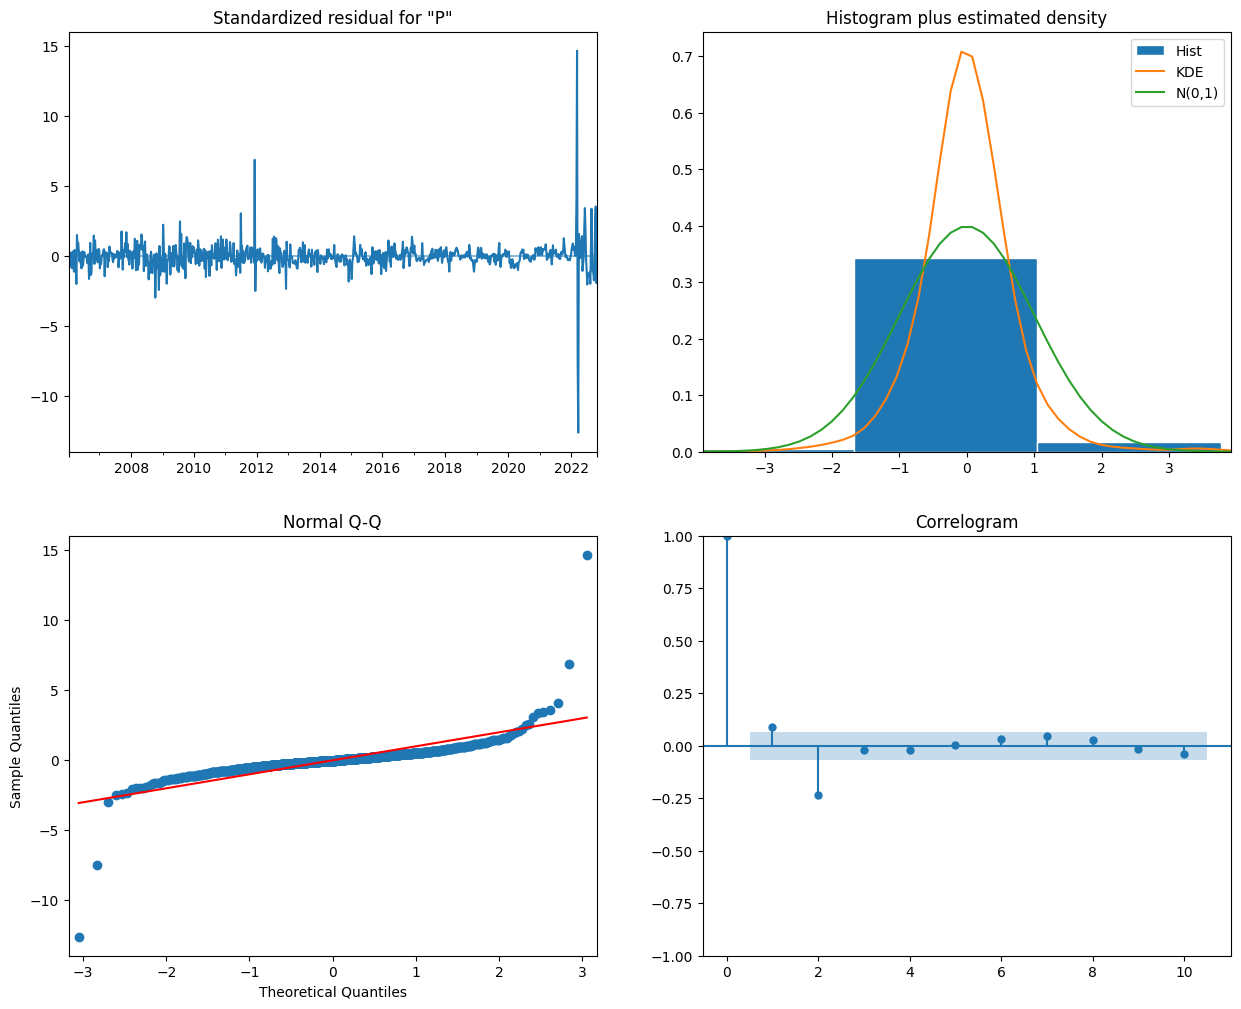

In [ ]:
# plot
sarima_result.plot_diagnostics(figsize=(15, 12))
plt.show()

### PREDICTION

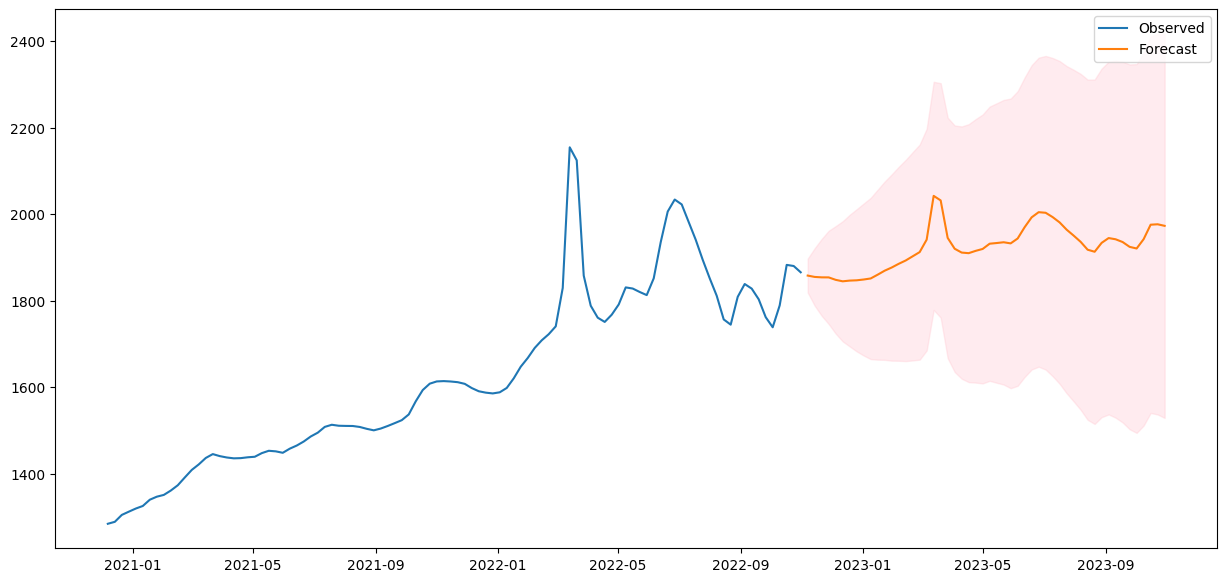

In [ ]:
# Make forecast
forecast = sarima_result.get_forecast(steps=52)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(15, 7))
plt.plot(time_series.index[-100:], time_series[-100:], label='Observed')
plt.plot(predicted_mean.index, predicted_mean, label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

## **Product Id 6**
Here we have started with product ID 6 which is Residual fuel oil.

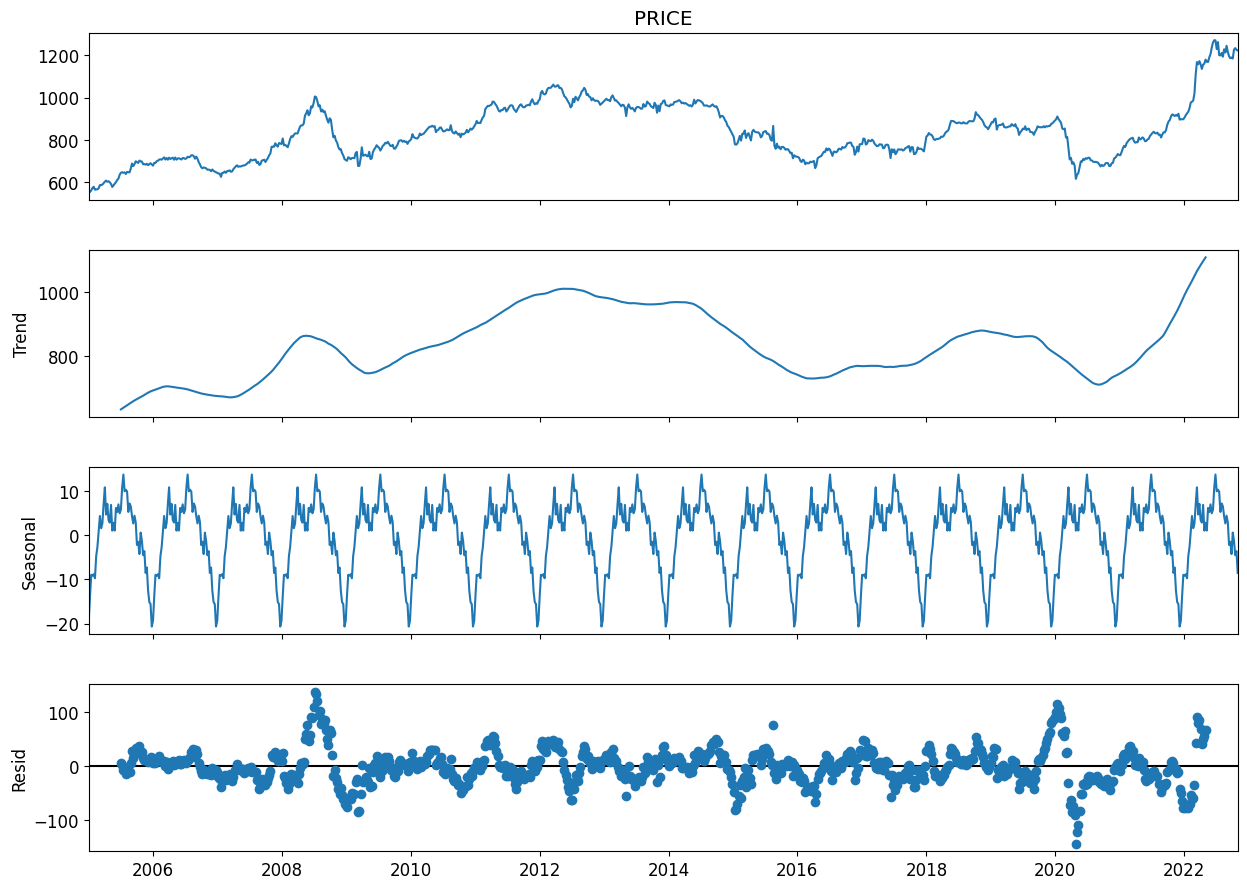

In [ ]:
# Selecting the data for Product ID 1
product_id_6_data = filled_df[filled_df['PRODUCT_ID'] == 6]['PRICE']

# Performing seasonal decomposition on monthly data
# Assuming an additive model for simplicity; this can be adjusted based on the data's characteristics
decomposition = seasonal_decompose(product_id_6_data, model='additive', period=52)  # Weekly data, hence period=52

# Plotting the decomposed components of the time series
decomposed_fig = decomposition.plot()
decomposed_fig.set_size_inches(14, 10)
plt.show()


* The topmost line plot illustrates the observed price over time, displaying fluctuations with an overall upward trend from 2006 to 2022. This gradual increase suggests a positive price trend.

* Directly below, the second plot reveals the trend component, presenting a smoothed curve capturing the long-term progression of prices. It reflects the general upward movement, indicating an overall price increase over the observed period.

* Following that, the third plot represents the seasonal component, showcasing regular fluctuations occurring at specific intervals within each year. These patterns may be linked to annual cycles, holidays, or other recurring events, contributing to the observed seasonal variations in prices.

* Finally, the fourth plot at the bottom portrays the residuals or noise in the data. Residuals represent variations not explained by the trend or seasonality, reflecting random fluctuations resulting from various factors impacting prices over time.

### VISUALIZATION

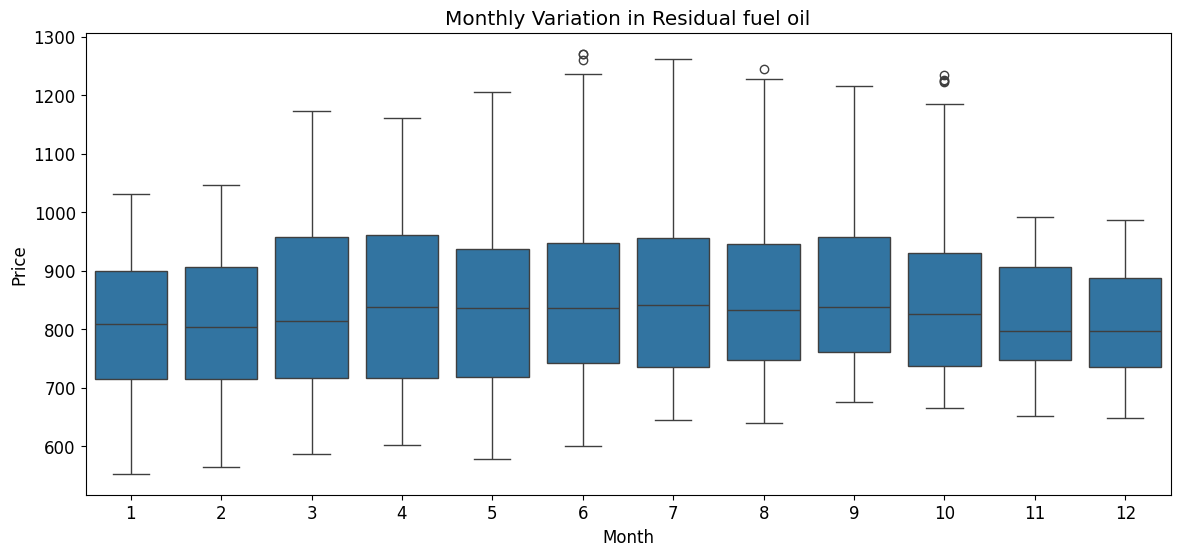

In [ ]:
#Box Plot of Prices by Month
plt.figure(figsize=(14, 6))
sns.boxplot(x=product_id_6_data.index.month, y=product_id_6_data.values)
plt.title('Monthly Variation in Residual fuel oil')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

The middle 50% of data points (prices) fall within the box.
The whiskers extend above and below each box, indicating the variability outside the upper and lower quartiles.
Outliers (represented by circles) lie beyond the whiskers and indicate extreme price values.

Month 6 (June): Prices peak significantly higher than other months.

Month 8 (August): Another peak in prices.

Month 10 (October): Yet another peak.

Months 1, 2, and 12 seem to have relatively lower median prices.

### TIME SERIES DESCRIPTION
The time series exhibits both trend and seasonality, yet it is non-stationary, implying that its statistical attributes vary over time.

In [ ]:
adf_test = adfuller(product_id_6_data)
adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                  -1.214995
p-value                          0.667112
#Lags Used                       3.000000
Number of Observations Used    927.000000
Critical Value (1%)             -3.437424
Critical Value (5%)             -2.864663
Critical Value (10%)            -2.568433
dtype: float64

* The p-value is 0.667112.It represents the probability that the observed data could occur under the null hypothesis (which assumes non-stationarity).A higher p-value suggests weaker evidence against the null hypothesis.
* The time series is likely non-stationary based on this test.

<Figure size 1400x600 with 0 Axes>

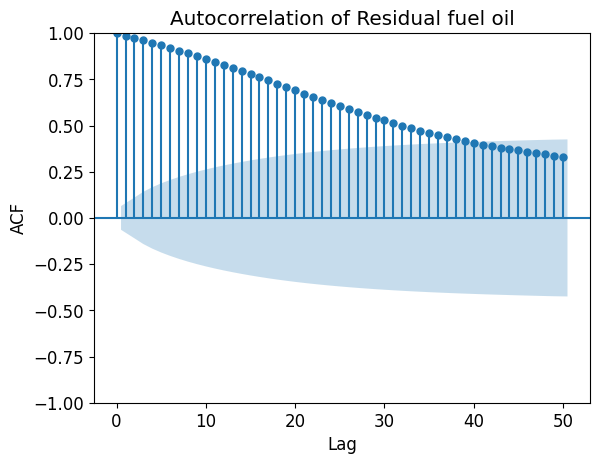

In [ ]:
plt.figure(figsize=(14, 6))
plot_acf(product_id_6_data, lags=50)  # Adjust the number of lags as needed
plt.title('Autocorrelation of Residual fuel oil')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

The strong positive autocorrelation at lag 0 suggests that recent prices influence current prices significantly.

The gradual decay in autocorrelation implies that price changes are somewhat predictable in the short term (up to a certain lag).

The negative autocorrelation beyond a certain lag may indicate seasonality or other complex patterns.

<Figure size 1400x600 with 0 Axes>

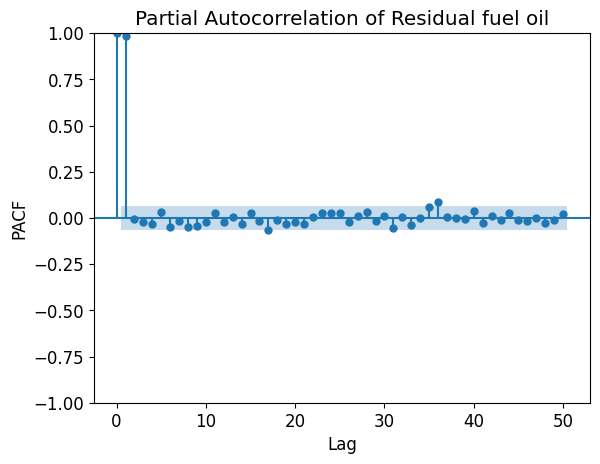

In [ ]:
plt.figure(figsize=(14, 6))
plot_pacf(product_id_6_data, lags=50)
plt.title('Partial Autocorrelation of Residual fuel oil')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

The strong positive autocorrelation at lag 0 implies that recent residual fuel oil prices influence current prices significantly.

The absence of significant correlations at other lags indicates that the residuals are relatively independent beyond the immediate past.

### MODELS

### LSTM

Epoch 1/10
23/23 [==============================] - 6s 16ms/step - loss: 0.0298
Epoch 2/10
23/23 [==============================] - 0s 16ms/step - loss: 0.0033
Epoch 3/10
23/23 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 4/10
23/23 [==============================] - 0s 16ms/step - loss: 0.0015
Epoch 5/10
23/23 [==============================] - 0s 17ms/step - loss: 0.0015
Epoch 6/10
23/23 [==============================] - 0s 16ms/step - loss: 0.0014
Epoch 7/10
23/23 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 8/10
23/23 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 9/10
23/23 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 10/10
6/6 [==============================] - 1s 5ms/step


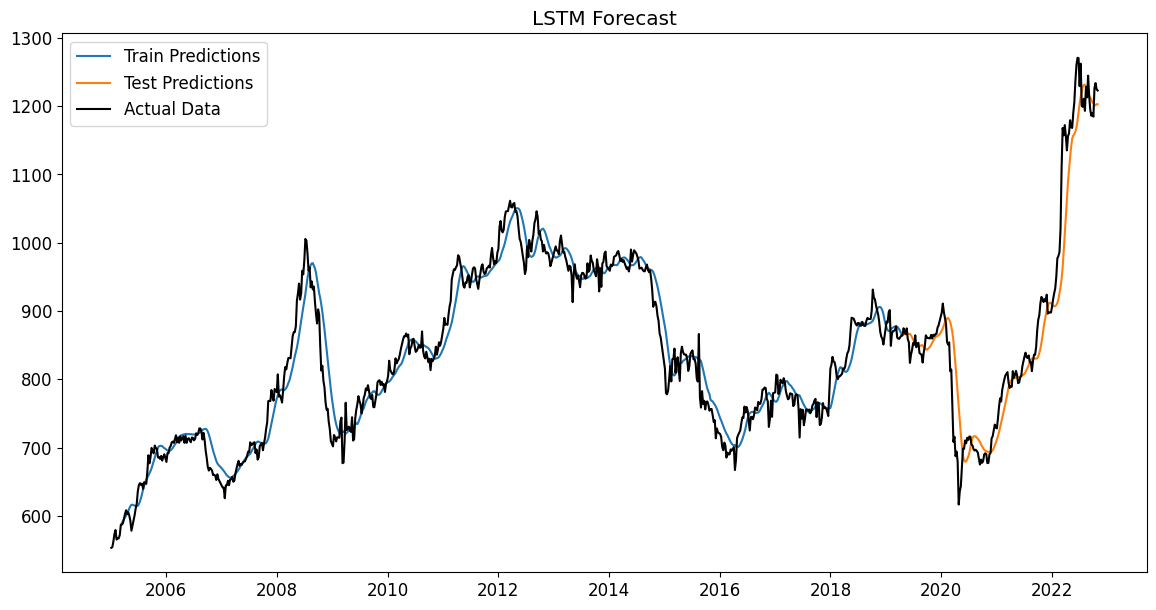

In [ ]:
# Reshaping the data to make it compatible with MinMaxScaler
data = product_id_6_data.values.reshape(-1, 1)

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Defining function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


sequence_length = 10

X, y = create_sequences(scaled_data, sequence_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping input data to be 3-dimensional (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Building LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scaling to get actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)

plt.figure(figsize=(14, 7))
plt.plot(product_id_6_data.index[sequence_length:len(train_predict)+sequence_length], train_predict, label='Train Predictions')
plt.plot(product_id_6_data.index[len(train_predict)+sequence_length:], test_predict, label='Test Predictions')
plt.plot(product_id_6_data.index, product_id_6_data, label='Actual Data', color='black')
plt.title('LSTM Forecast')
plt.legend()
plt.show()


The LSTM model seems to have done a good job of learning the patterns in the training data, as indicated by the close match between the blue and black lines.
The model has captured the overall trend in the test set; however, there is some deviation from the actual data points, which is expected since real-world data often contains noise and other complexities.
The sharp rise at the end of the actual data is somewhat captured by the test predictions, suggesting the model has learned the recent trend, although the predicted increase starts slightly earlier than the actual data.
However, The orange line segment is the model’s predicted values, which are compared against the actual data that wasn't seen by the model during training.

### SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              PRICE   No. Observations:                  931
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -3756.618
Date:                            Tue, 02 Apr 2024   AIC                           7519.237
Time:                                    19:34:01   BIC                           7533.570
Sample:                                01-03-2005   HQIC                          7524.718
                                     - 10-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0021      0.021     -0.100      0.920      -0.043       0.038
ar.S.L52      -0.4791      0.023   

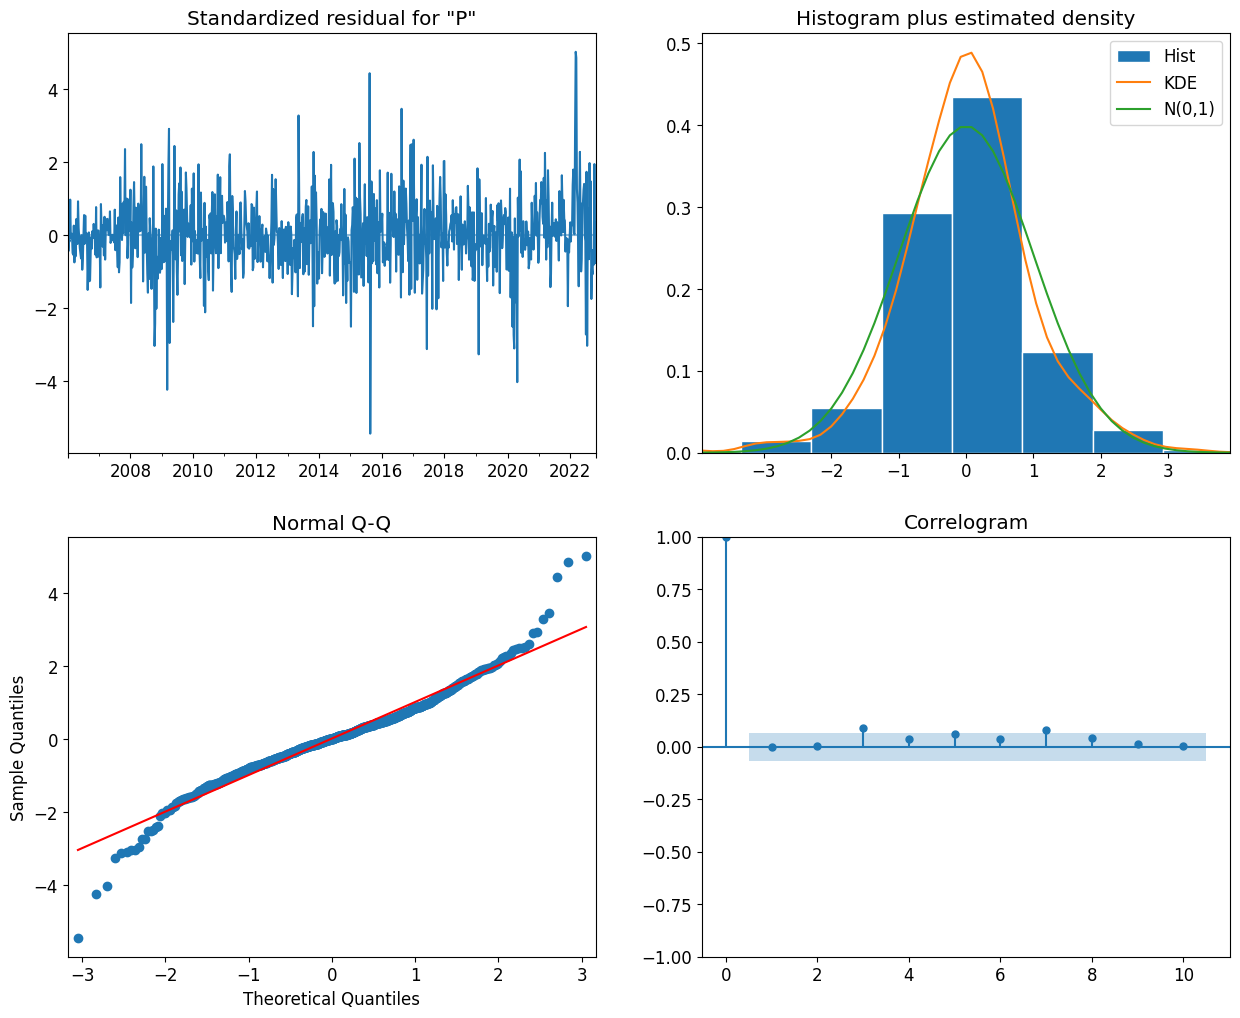

In [ ]:
sarima_model = SARIMAX(product_id_6_data, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52))
sarima_results = sarima_model.fit()
print(sarima_results.summary())
#Plots for SARIMA model
sarima_results.plot_diagnostics(figsize=(15, 12))
plt.show()

* Standardized Residuals:
The top left plot shows the standardized residuals over time. You'd hope to see no obvious patterns; residuals should be random, indicating that the model has captured all information in the data.
In this case, the residuals seem to fluctuate around zero without a discernible pattern, which is a good sign. However, there are some outliers that suggest occasional shocks not captured by the model.
* Histogram plus Estimated Density:
The top right plot compares the distribution of the standardized residuals to a normal distribution (shown in green). The blue line (KDE - Kernel Density Estimate) is an estimate of the residual distribution.
The residuals seem to have a distribution with a peak slightly higher than the normal distribution's peak and a bit of skewness to the right, suggesting a slight deviation from normality. However, the tails are within reasonable bounds of the normal distribution.
* Normal Q-Q Plot:
The bottom left plot is a Quantile-Quantile plot that compares the quantiles of the residuals with the expected quantiles from a normal distribution.
* Most points lie on the red line, indicating that the residuals are normally distributed, which is an assumption of the SARIMA model. The slight deviation in the tails suggests the presence of outliers or extreme values that the model does not account for perfectly.
* Correlogram (ACF Plot):
The bottom right plot is the autocorrelation function (ACF) of the residuals. Ideally, all autocorrelations for lagged values should be within the blue area, which represents a confidence interval (typically 95%).
This plot indicates that most autocorrelations are within the confidence interval, suggesting that the residuals are white noise—meaning the model has captured the signal in the data well.

### PREDICTION

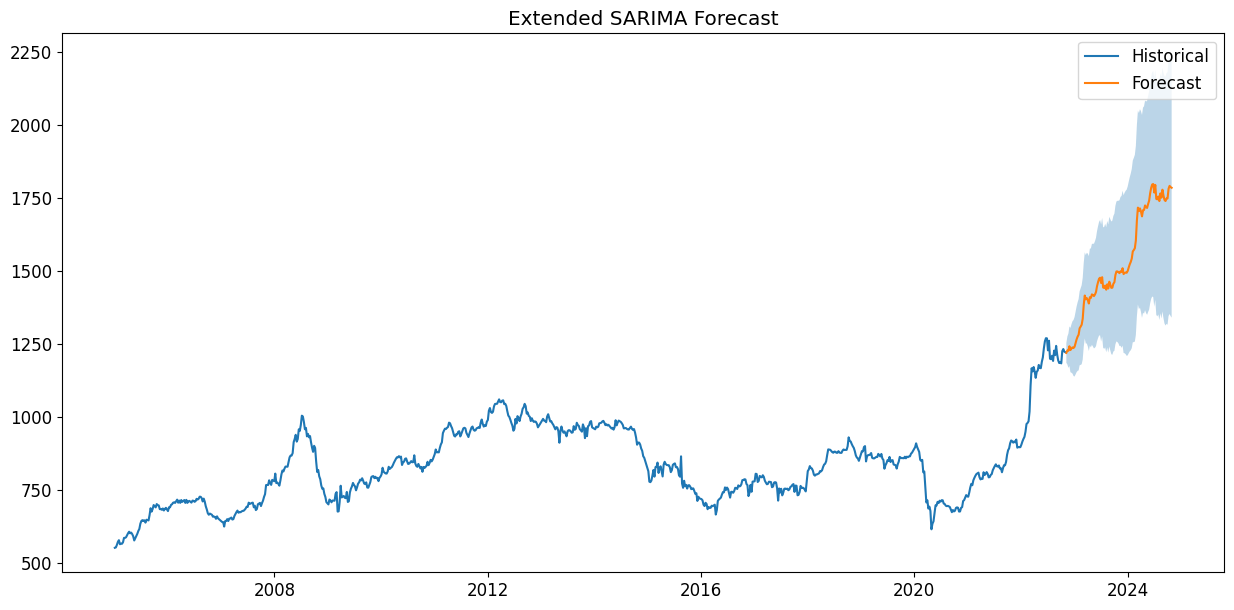

In [ ]:
n_periods = 104

forecast = sarima_results.get_forecast(steps=n_periods)
forecast_index = pd.date_range(product_id_6_data.index[-1] + pd.Timedelta(weeks=1), periods=n_periods, freq='W-MON')
pred_conf = forecast.conf_int()

plt.figure(figsize=(15, 7))
plt.plot(product_id_6_data.index, product_id_6_data, label='Historical')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], alpha=0.3)

plt.title('Extended SARIMA Forecast')
plt.legend()
plt.show()

* Historical Trend: The historical data shows variability with what seems like an upward trend starting around 2020, leading to a steep increase in prices as the historical data ends.
Forecast Trend: The model forecasts a continued increase in prices shortly after the last historical point, followed by a forecasted leveling off or even a slight decrease. However, this is within the context of the larger upward trend that began in 2020.
* Confidence Intervals: The shaded area represents the confidence intervals, which quantify the uncertainty associated with the forecast. The intervals are relatively narrow at the beginning of the forecast period, suggesting more certainty in the immediate future. As the forecast extends, the confidence intervals widen significantly, reflecting increasing uncertainty in the predicted prices the further out we go. This is a typical characteristic of time series forecasts.
* Volatility: There is noticeable volatility in the historical data, with several peaks and troughs. The forecast suggests this volatility will continue into the future but does not appear to capture the extent of variability seen in the recent historical data, possibly due to the smoothing effect of the model.
* Possible Influences: The steep upward trend at the end of the historical data and into the forecast could be influenced by recent events or changes in the market that the model expects to continue into the immediate future.
* In conclusion, the forecast suggests a cautious outlook on the future of prices, with a short-term increase followed by stabilization. However, given the high volatility in the recent historical data, there should be an understanding that the forecast could change with new information and that these projections should be taken as one possible future scenario.

# PROJECT PART2 CONCLUSION
This time series project has been meticulously undertaken against a backdrop of intensifying geopolitical strife and evolving economic policies affecting fuel prices across Europe. With the predictions capturing the trend of rising prices amid supply disruptions from Russia, the forecast serves as a critical tool for policymakers. The aim is to provide them with a data-driven basis for crafting strategies that can directly benefit the populace, enabling informed decisions that affect daily life.

As tensions mount over the situation in Taiwan with China and NATO signals caution over potential trade upheavals, the necessity for such predictive analysis becomes even more pronounced. The project's insights are intended to empower European citizens, especially those dependent on Russian gas, to proactively navigate the financial uncertainties by considering more sustainable and economical alternatives such as electric vehicles and cycling.

By anticipating price movements and understanding their broader implications, this project supports both individual and collective shifts towards energy-efficient solutions. This not only fosters economic savings but also fortifies efforts towards achieving energy independence. Ultimately, the project strives to inform and bolster policymakers' capacity to safeguard their constituencies against escalating fuel costs and the vagaries of international trade dynamics.


# **Group Contributions**:
### Time spent connecting to discuss by the team:
1. Data preprocessing steps discussion call regarding duplicates,missing weeks, how to fill them
2. How to approach this dataset and splitting work after analysing that dataset is multiple time series
3. Cross checking models and analyzing performance

## Work done by individuals:

## Ayana Holla Pandeshwara:-
Product ID 1:

**Data Preprocessing**:Finding the missing weeks and interpolating the missing values

**Time series decomposition**: Understanding the three plots and verifying results

**Time Series Visualization**

**Description of Time series**: Performing ADF and understanding if the data is stationary and checking ACF and PACF to understand what P,D,Q value we need to use

**TS models** (with transformations)- ARIMA, SARIMA and Auto Arima

**Predictions**

**Conclusion**

**Group Contribution**

## Shubham Patil:-
Product ID 2:

**Data Preprocessing**:checked for all missing values and basic shape and decription of the data followed by the basic time series plot

**Time series decomposition**: Understanding the three plots and verifying results

**Time Series Visualization**

**Description of Time series**: Performing ADF and understanding if the data is stationary

**TS models** (with transformations): SARIMA

**Predictions**

**Group Contribution**

**Coordinated team calls**

## Vineela Kunisetti:-
Product ID 6:

**Data Preprocessing**: checked for duplicates and replaced them with mean value

**Time series decomposition**: Understanding the three plots and verifying results

**Time Series Visualization**

**Description of Time series**: Performing ADF and understanding if the data is stationary and checking ACF and PACF to understand what P,D,Q value we need to use

**TS models** (with transformations): LSTM, SARIMA

**Predictions**

**Group Contribution**

**Formatted the Collab Notebook**

## References:
1. https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
2. https://www.listendata.com/2023/11/find-unique-values-in-column-pandas.html#:~:text=The%20unique()%20method%20returns%20a%20NumPy%20array%20of%20unique%20values.&text=Incase%20you%20want%20the%20unique,use%20the%20tolist()%20function.&text=The%20drop_duplicates()%20method%20is,DataFrame%20and%20return%20unique%20values.
3. https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/
4. https://www.linkedin.com/advice/1/how-do-you-compare-evaluate-different-arima-model-orders#:~:text=One%20way%20to%20compare%20different,model%20with%20the%20lowest%20value.
5. https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/
6. https://otexts.com/fpp2/seasonal-arima.html
7. https://medium.com/@ozdogar/time-series-forecasting-using-sarima-python-8db28f1d8cfc
8. https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/
9. https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf

